<center><h1> Data Camp Project</h1> </center>
<center><h1>Bicycle surplus prediction</h1></center>
<center> <h4>Authors : Ghassen Ben Hassine, Firas Rhimi, Etienne Lenaour, Ryme Kabak, Elyes Karray, Mehdi Bennaceur</h4></center>

<img border="0" src="Images\Bike.jpeg" width="1000"> 


## Table of Contents

0. [Introduction](#Introduction)
1. [Business Motivation](#Business-Motivation)
2. [Data Construction](#Data)
3. [Evaluation metric](#Evaluation-metric)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Feature Engineering](#Feature-Engineering)
6. [Predictions](#Predictions)

# 0. Introduction

New York Bike Sharing system provides a carbon-free way of transportation to more than 50 millions person each month. More than 800 hundreds bike docking stations are available across the city and are open 24/7. It was in part conceived to decrease traffic and usage in other public transport services (subway, underground etc...).

Thanks to all the docking stations located in New York City, a large amount of data is collected. This data can be extremely useful in improving the user experience by:

- Analyzing the number of trips made in a given hour using the Bike Sharing system in order to improve traffic flow. 
- Predicting the most frequent trips in order to provide time-saving itineraries at jammed locations.
- Forecasting the difference between the number of bikes leaving and arriving at a given time and date. This variable can be very useful for the purpose of recharging/discharging docking stations in order to balance offer and demand.

# 1. Business Motivation 


The data colled from the bike stations is useful to answer various problems. 
In this project, we will focus on forecasting the surplus at a given time.

From a practical point of view, we want to build an algorithm that takes as input the date, time of the day, meteorological data and station and is able to predict the surplus situation for a given docking station at a given time.  
Consequently, the company running the New York Bike Sharing system can use this algorithm to order the transferring of bikes from the surplus stations to the deficit ones. Meeting the demand in a quick and autonomous manner will guarantee a steady traffic flow and more importantly, a satisfied customer.

In order to respond effectively to this problem we need the following information for all bike trips :

- The departure and arrival station **(1)**
- The date of departure and the date of arrival **(2)**
- The meteorological data  **(3)**

**(1)** and **(2)** were provided by a database found on the site https://www.citibikenyc.com/system-data. Moreover, we web-scrapped **(3)** from https://freemeteo.fr/. 

We will further discuss the used datasets in the next section.

# 2. Dataset Construction


# `bike_data.csv`
This dataset was built from an extract of https://www.citibikenyc.com/system-data. It includes historical data of bike trips in NYC between 2016 and 2018: 
* `Trip Duration` - The duration of the trip in seconds.
* `Start Time` - Start date and time.
* `Stop Time` - Stop date and time.
* `Start Station ID` 
* `Start Station Name`
* `Start Station Longitude` - Start station spatial coordinates.
* `Start Station Latitude` - Start staion spatial coordinates.
* `End Station ID` 
* `End Station Name`
* `End Station Longitude` - End station spatial Coordinates.
* `End Station Latitude` - End station spatial coordinates.
* `Bike ID` 
* `User Type` - Customer = 24-hour pass or 3-day pass user, Subscriber = Annual Member.
* `Birth Year` - Birth year of the customer.
* `Gender` - Gender of the customer : 0 = Unknown, 1 = Male, 2 = Female.

In [1]:
# Imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap

In [2]:
from get_data import *
raw_data = get_bike_data()
raw_data.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0


From this raw dataset, we extract a new dataset that will be used in the challenge as a training set. This new dataset will include : 
* `Year` 
* `Month` 
* `Day` 
* `Hour` 
* `Station ID` 
* `Station Name`
* `Longitude` 
* `Latitude` 
* `Surplus` - The target we want to predict. It is **the difference** between the number of bikes that **come** in a given station and the number of bikes that **leave** that same station at **a given time and date**.

The necessary preprocessing to get the train set is done in the `get_data.py` file via the `get_flow_data` function. 


In [3]:
train_data = get_flow_data()
train_data.head(5)

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,1.0
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,0.0
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,2.0
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,-1.0
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,2.0


## `weather_data.csv`

The weather database has been scraped from https://freemeteo.fr/. 

The code is in the `get_data_weather.py` file. 

In [4]:
weather = pd.read_csv('data/weather/Weather.csv')
weather.head()

,Hour,Temperature,Apparent Temperature,Wind,Relative Humidity,Date
0,00:51,6°C,4°C,Variable à 7 Km/h,49%,2016-01-01
1,01:51,5°C,4°C,Variable à 6 Km/h,53%,2016-01-01
2,02:51,5°C,3°C,280°7 Km/h,57%,2016-01-01
3,03:51,5°C,2°C,280°15 Km/h,57%,2016-01-01
4,04:51,4°C,0°C,270°17 Km/h,61%,2016-01-01


## `Capacities dataset`


Another dataset that can be used in the challenge is called "Capacities" : It represents the capacity(maximal number of bikes) of some stations in NewYork. The scraping of this dataset is done from https://member.citibikenyc.com/map/ using the script "get_station_capacities.py"

In [5]:
import json
stations_path = 'data/stations.json'
with open(stations_path, 'r') as f:
    stations_with_capacities = json.load(f)

Capacities =pd.DataFrame({'Station Name':list(stations_with_capacities.keys()), 'Capacity':list(stations_with_capacities.values())})
Capacities.head()

,Station Name,Capacity
0,S Portland Ave & Hanson Pl,27
1,W 13 St & 5 Ave,29
2,W 11 St & 6 Ave,56
3,E 7 St & Avenue A,31
4,Liberty St & Broadway,45


# 3.Evaluation metric

The idea is to penalize differently a prediction of a higher surplus than the true one and the prediction of a lower surplus than the true one. 

We may define the loss as follows (called **Pinball loss**) : 


$$l(y_{true},y_{pred})= max(-(1-\tau)(y_{pred}-y_{true}),\tau (y_{pred}-y_{true})) = \begin{cases} \tau(y_{pred}-y_{true}) & \text{if } y_{pred} \geq y_{true} \\  -(1-\tau)(y_{pred}-y_{true}) & \text{if } y_{pred} < y_{true}\end{cases}$$

where $\tau \in ]0,1[$ is a parameter that quantifies the degree of penalization for each scenario.

In our case, we would like to penalize more heavily the fact that the model overestimates the surplus (predicts a higher value of surplus than the true value). This can be done by choosing a value of $\tau >0.5 $. For this challenge, we chose **$\tau=0.7$**. 

First, let's visualize the loss function and then create our scoring metric.


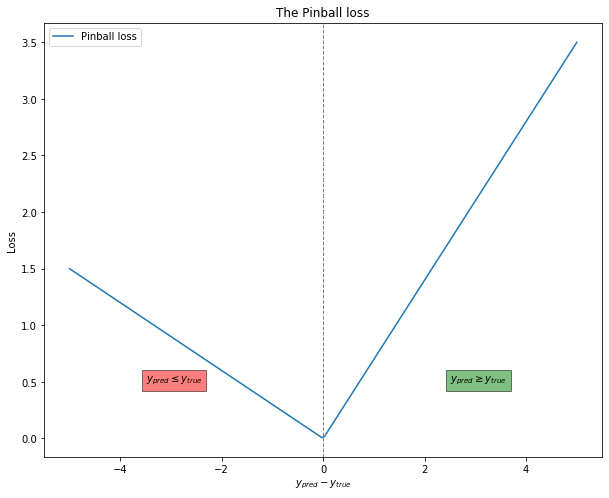

In [6]:
# Visualize the pinball loss 
plt.figure(figsize=(10, 8))
tau = 0.7
x= np.linspace(-5,5,200) # x= y_pred - y_true
plt.plot(x,np.maximum(-(1-tau)*x,tau*x),label= "Pinball loss")
plt.xlabel('$y_{pred} - y_{true}$')
plt.ylabel('Loss')
plt.legend()
plt.title('The Pinball loss')
plt.text(2.5, 0.5, '$y_{pred} \geq y_{true}$', bbox=dict(facecolor='green', alpha=0.5))
plt.text(-3.5, 0.5, '$y_{pred} \leq y_{true}$', bbox=dict(facecolor='red', alpha=0.5))
plt.axvline(x=0, linewidth=1, color='gray', ls='--')
plt.show()

In [7]:
# define scoring function 

from sklearn.metrics import make_scorer

def loss(y_true, y_pred, tau=0.7): 
    return np.mean(np.maximum(-(1 - tau) * (y_pred - y_true), tau * (y_pred - y_true)))

pinball_loss = make_scorer(loss, greater_is_better=False) # scoring=fan_loss in cross_val_score

# 4. Exploratory Data Analysis

In [8]:
X_df, y_array = train_data.drop(columns= ['Surplus']) ,train_data['Surplus'].values

In [9]:
y_array

array([ 1.,  0.,  2., ..., -1., -1., -1.])

In [10]:
train_data.count()

Year            511903
Month           511903
Day             511903
Hour            511903
Station ID      511903
Station Name    511903
Longitude       511903
Latitude        511903
Surplus         511903
dtype: int64

In [11]:
train_data.describe(include='all')

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
count,511903.000000,511903.000000,511903.000000,511903.000000,511903.000000,511903,511903.000000,511903.000000,511903.000000
unique,NaN,NaN,NaN,NaN,NaN,199,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Grove St PATH,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,20557,NaN,NaN,NaN
mean,2017.111619,6.963298,15.755520,13.518585,3244.058263,NaN,-73.988233,40.690377,0.000000
std,0.822150,3.229329,8.795291,5.687800,132.903913,NaN,2.117686,1.164652,3.682759
min,2016.000000,1.000000,1.000000,0.000000,127.000000,NaN,-74.096937,0.000000,-54.000000
25%,2016.000000,4.000000,8.000000,9.000000,3194.000000,NaN,-74.055701,40.717732,-1.000000
50%,2017.000000,7.000000,16.000000,14.000000,3209.000000,NaN,-74.046305,40.721651,0.000000
75%,2018.000000,10.000000,23.000000,18.000000,3269.000000,NaN,-74.038914,40.727596,1.000000


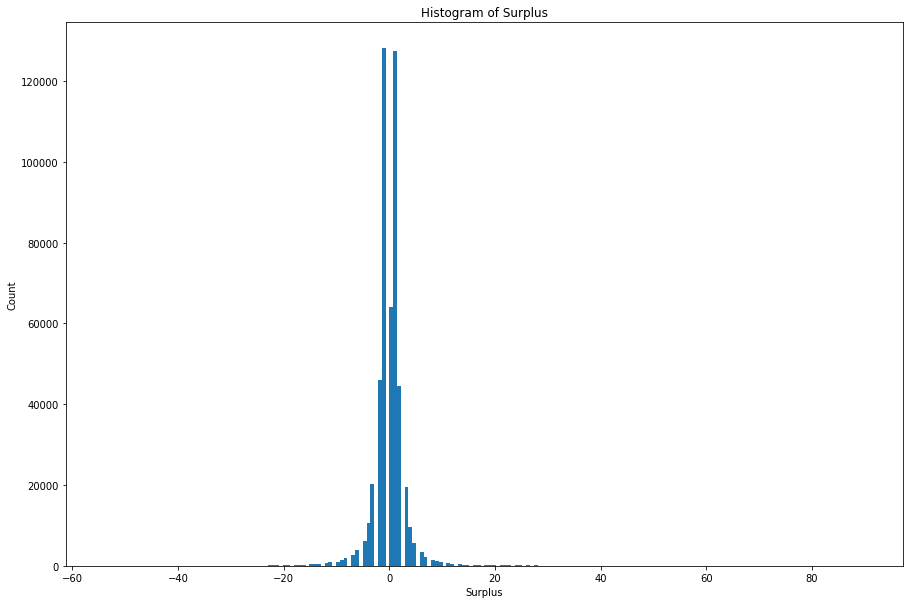

In [12]:
# Histogram
plt.figure(figsize=(15,10))
plt.hist(y_array, bins=200)
plt.title('Histogram of Surplus')
plt.xlabel('Surplus')
plt.ylabel('Count')
plt.show()


Let's visualize the position of our docking stations in New York City:

In [13]:
#dockers coordinates 
coord=train_data[["Longitude", "Latitude"]]
coord2=coord.drop_duplicates(keep='first', inplace=False)  
coord2.shape

(203, 2)

In [14]:
map_1 = folium.Map(location=[40.717937, -73.982155], zoom_start=11,tiles='OpenStreetMap') # manually added centre
coord2.reset_index(inplace = True, drop = True)
for i in range(len(coord2)):  
        long = coord2.loc[coord2.index ==i]['Longitude'].values[0]
        lati = coord2.loc[coord2.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  fill_color = '#FF3333',
                            number_of_sides = 8, radius = 5).add_to(map_1)

In [15]:
display(map_1)

In [16]:
pos_surplus = train_data[train_data['Surplus']>0]   #215350
neg_surplus = train_data[train_data['Surplus']<0]   #222587
null_surplus = train_data[train_data['Surplus']==0] #63573

In [17]:
coord_pos=pos_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False) #184  
coord_neg=neg_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False)  #63
coord_null=null_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False) #63


In [18]:
map_2 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
map_3 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
map_4 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre

coord_pos.reset_index(inplace = True, drop = True)
coord_neg.reset_index(inplace = True, drop = True)
coord_null.reset_index(inplace = True, drop = True)

    
for i in range(len(coord_null)):  
        long = coord_null.loc[coord_null.index ==i]['Longitude'].values[0]
        lati = coord_null.loc[coord_null.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  
                            number_of_sides = 6, radius = 4).add_to(map_2)
        
        
for i in range(len(coord_neg)):  
        long = coord_neg.loc[coord_neg.index ==i]['Longitude'].values[0]
        lati = coord_neg.loc[coord_neg.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long], 
                            number_of_sides = 5, radius = 4).add_to(map_4)
    
for i in range(len(coord_pos)):  
        long = coord_pos.loc[coord_pos.index ==i]['Longitude'].values[0]
        lati = coord_pos.loc[coord_pos.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  
                            number_of_sides = 5, radius = 4).add_to(map_3)


In [19]:
display(map_2) # negative surplus

In [20]:
display(map_3) #pos surplus 

The dockers that tend to have negative or null surplus are located in **Jersey City**, which is a city 6.24 kms away from New York.

This can be interpreted as the following: People who work in New York might prefer to live in Jersey City (which is cheaper and more affordable) and can therefore use the bikes to "travel" to New York (for work or other purposes), leading to more bikes going OUT than coming IN, and hence **a negative or null surplus**.

Therefore, it is important to be able to monitor the surplus so that people from that area continue to use bikes for their daily short trips.

Here, we can see that the dockers are distributed across different districts of New York. These dockers tend to have positive surplus, which means that there are more bikes coming in than bikes leaving across Manhattan and Brooklyn. 


In [21]:
# Mean Surplus for a given station
df= train_data[['Surplus','Station ID']].groupby('Station ID').mean()
df.head()


,Surplus
Station ID,
127.0,1.0
128.0,1.0
146.0,1.0
147.0,1.0
152.0,1.0


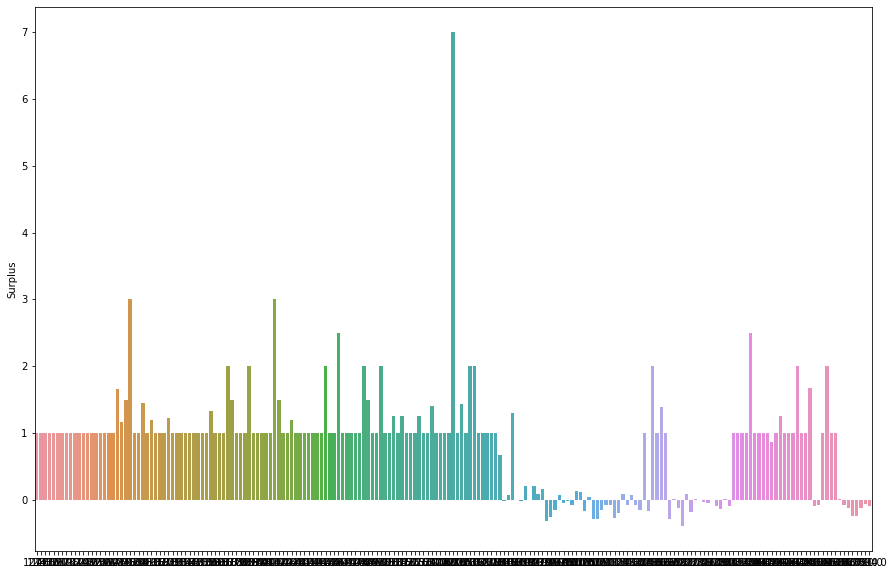

In [22]:
plt.figure(figsize=(15,10))
stations = list(df.index)
mean_surplus = df['Surplus']
sns.barplot(stations,mean_surplus)

In [23]:
df[df['Surplus']==7]

,Surplus
Station ID,
2021.0,7.0


In [24]:
train_data[train_data['Station ID']==2021] # We have the information for just 1 hour for this station 

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
106179,2017.0,1.0,25.0,17.0,2021.0,W 45 St & 8 Ave,-73.988597,40.759291,7.0


In [25]:
# Mean Surplus for a given Hour 
df=train_data[['Surplus','Hour']].groupby('Hour').mean()
df.head()

,Surplus
Hour,
0.0,0.046175
1.0,0.062973
2.0,0.053318
3.0,0.026421
4.0,-0.007485


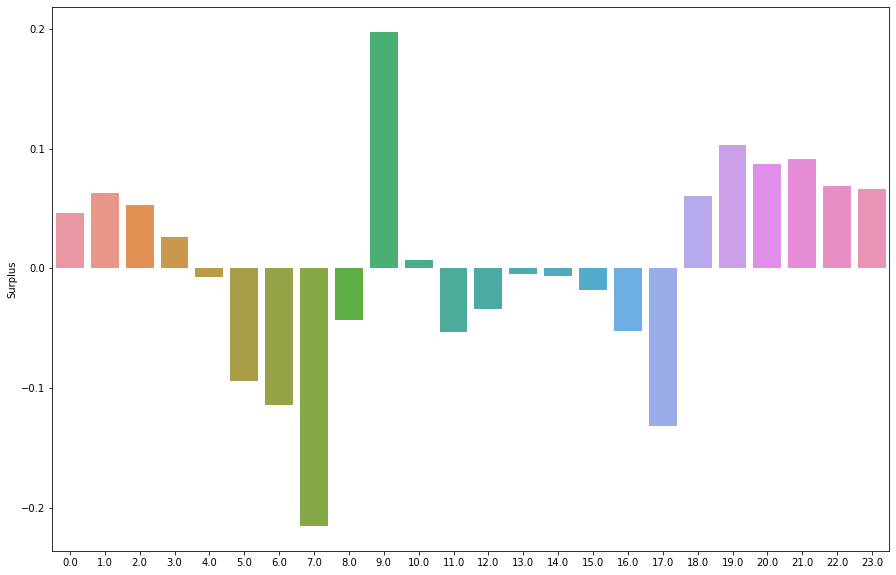

In [26]:
plt.figure(figsize=(15,10))
hour = list(df.index)
mean_surplus = df['Surplus']
sns.barplot(hour,mean_surplus)

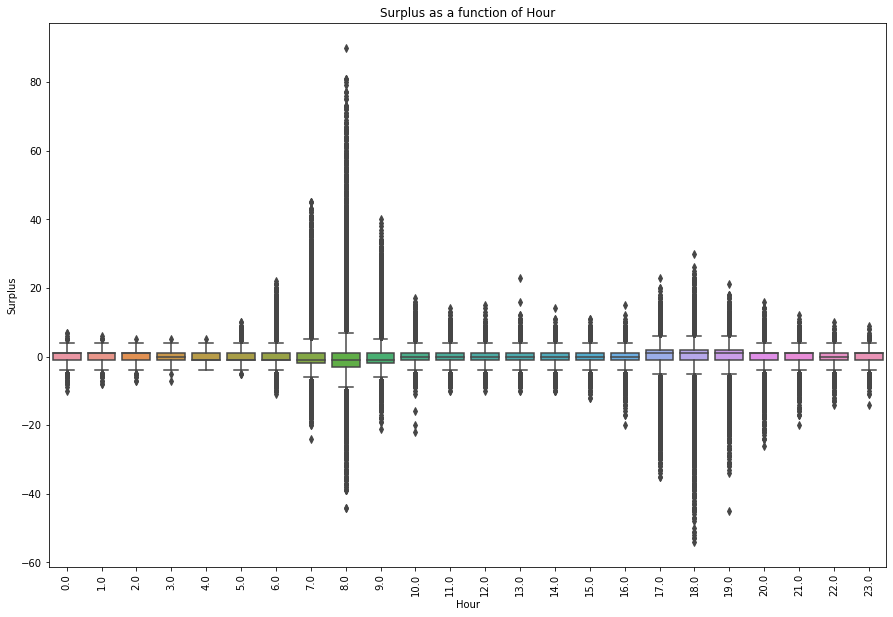

In [27]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Hour'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Hour')
plt.show()


## The Meteorological Data


In [28]:
weather.head()

,Hour,Temperature,Apparent Temperature,Wind,Relative Humidity,Date
0,00:51,6°C,4°C,Variable à 7 Km/h,49%,2016-01-01
1,01:51,5°C,4°C,Variable à 6 Km/h,53%,2016-01-01
2,02:51,5°C,3°C,280°7 Km/h,57%,2016-01-01
3,03:51,5°C,2°C,280°15 Km/h,57%,2016-01-01
4,04:51,4°C,0°C,270°17 Km/h,61%,2016-01-01


In [29]:
# put date in the right form
date = pd.to_datetime(weather['Date'],format='%Y-%m-%d')
weather['Year'] = date.dt.year
weather['Month'] = date.dt.month
weather['Day'] = date.dt.day
weather['Hour'] = pd.to_datetime(weather['Hour'], format='%H:%M').dt.hour
weather.drop_duplicates(subset =['Hour','Day','Month','Year'],keep = 'first',inplace=True) 
weather.drop(columns=['Date'],inplace=True)

In [30]:
# put meteo data in the right form 

def process_wind(x):
    if 'Rafales de Vent' in x:
        return 2 # high value
    elif 'Calme' in x:
        return 0 # low value
    else:
        return 1 # medium value
weather['Wind'] = weather['Wind'].apply(process_wind)
weather['Apparent Temperature'] = (weather['Apparent Temperature'].str[:-2]).astype(float)
weather['Temperature'] = (weather['Temperature'].str[:-2]).astype(float)
weather['Relative Humidity'] = (weather['Relative Humidity'].str[:-1]).astype(float)

In [31]:
merged_data = pd.merge(X_df, weather, on=['Year', 'Month', 'Day', 'Hour'], how='left', left_index=True)
merged_data['Surplus'] = y_array

merged_data.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Temperature,Apparent Temperature,Wind,Relative Humidity,Surplus
0.0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,6.0,4.0,1.0,49.0,1.0
0.0,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,6.0,4.0,1.0,49.0,0.0
0.0,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,6.0,4.0,1.0,49.0,2.0
1.0,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,5.0,4.0,1.0,53.0,-1.0
1.0,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,5.0,4.0,1.0,53.0,2.0


In [32]:
merged_data['Surplus'] = y_array
merged_data.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Temperature,Apparent Temperature,Wind,Relative Humidity,Surplus
0.0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,6.0,4.0,1.0,49.0,1.0
0.0,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,6.0,4.0,1.0,49.0,0.0
0.0,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,6.0,4.0,1.0,49.0,2.0
1.0,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,5.0,4.0,1.0,53.0,-1.0
1.0,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,5.0,4.0,1.0,53.0,2.0


# 5. Feature Engineering

## Day of week 

In [33]:
ts = pd.to_datetime(X_df[['Year','Month','Day']])
X_df['Weekdday']=ts.dt.weekday
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Weekdday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,4
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,4
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,4
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,4
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,4


In [34]:
## Groupby day of the week
train_data['Weekday'] = ts.dt.weekday 
df=train_data[['Surplus','Weekday']].groupby('Weekday').mean()
df.head()

,Surplus
Weekday,
0,0.001376
1,0.000160
2,0.000143
3,-0.000672
4,-0.001446


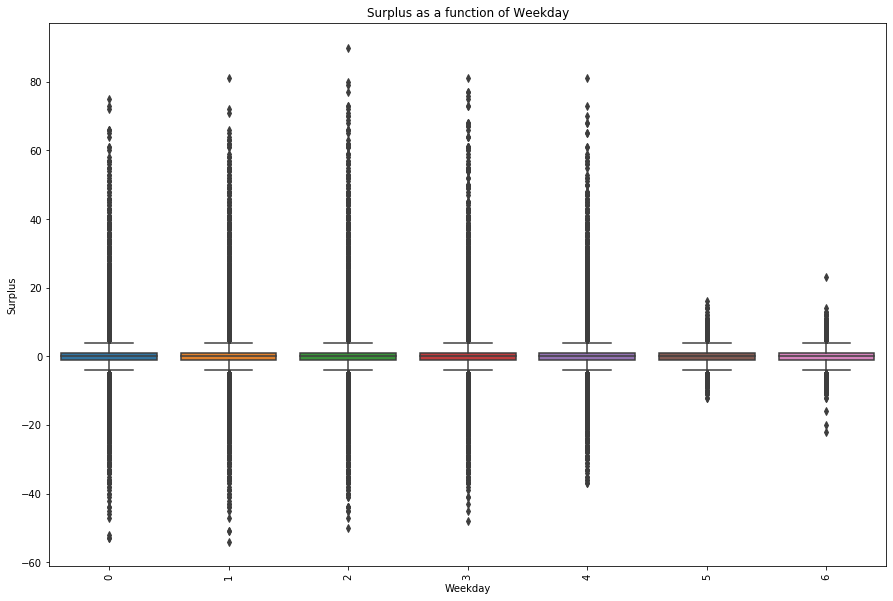

In [35]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Weekday'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Weekday')
plt.show()


In [36]:
ts = pd.to_datetime(X_df[['Year','Month','Day']])
X_df['Weekday']=ts.dt.weekday
train_data['Weekday'] = ts.dt.weekday 
df=train_data[['Surplus','Weekday']].groupby('Weekday').mean()
pg=train_data[['Weekday','Hour','Surplus']].groupby(['Weekday','Hour']).mean()
pg.head()

Surplus
Weekday Hour          
0       0.0   0.048741
        1.0   0.072059
        2.0   0.008721
        3.0   0.003610
        4.0  -0.016495

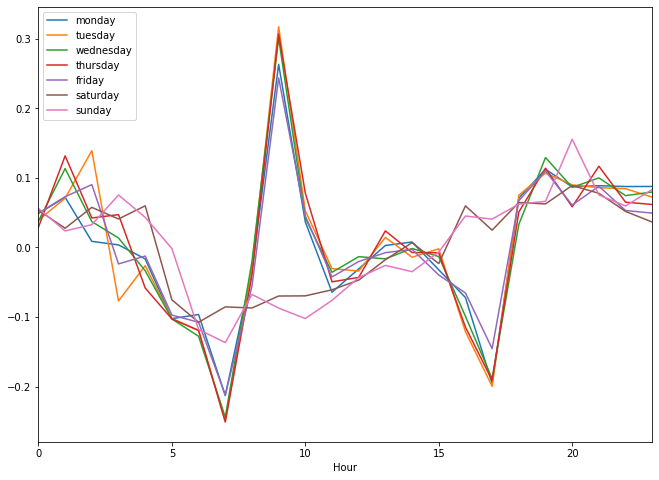

In [37]:
ax1 = plt.gca()
pg['Surplus'][0].plot(kind='line',ax=ax1,figsize=(11,8))
pg['Surplus'][1].plot(kind='line',ax=ax1)
pg['Surplus'][2].plot(kind='line',ax=ax1)
pg['Surplus'][3].plot(kind='line',ax=ax1)
pg['Surplus'][4].plot(kind='line',ax=ax1)
pg['Surplus'][5].plot(kind='line',ax=ax1)
pg['Surplus'][6].plot(kind='line',ax=ax1)
ax1.legend(['monday','tuesday','wednesday','thursday','friday','saturday','sunday'],loc='upper left')
plt.show()


It is interesting to notice that during weekdays (from Monday to Friday), **two negative peaks** are observed at 7 AM and at 6 PM and **two positive pics** at 9 AM and 7-8 PM. 

This can be interpreted as the following: Customers tend to use the bikes to go to work early in the morning and head back home at the end of the afternoon. This pattern generates a big number of bikes going out and a fewer coming in during these hours, which explains the negative pics. On the other hand, people are expected to arrive at their work place between 9 and 10 AM and to their homes between 7 and 8 PM. Consequently, the number of bikes during those time slots starts to get higher, leading to an increase in the surplus.

Regarding the weekends, we can notice a flat distribution with more bikes used during the day.

## Holidays

During holidays, some people tend to stay at home with their families while others usually  go back to their home cities or countries by train or plane.
Hence, bike usage might differ during holidays and it's interesting to take this factor into account.

These are the official Federal and State Holidays that we will be considering in our algorithm:


- **New Year**: $1^{st}$ of January.


- **Martin Luther King Jr. Day**: Third Monday of January (In honour of Martin Luther King Jr who fought to defend racial equality).


- **President’s Day**: Third Monday of February (Celebrated in honour of George Washington and all of United States’ Presidents).


- **Memorial Day**: Last Monday of May (To remember the soldiers who died while serving in the country’s armed forces).


- **Independence Day**: $4^{th}$ of July. (On the July 4, 1776, 13 colonies became independent from British domination and formed the first States of the country).


- **Labor day**: First Monday of September.


- **Columbus Day**: Second Monday of October (Remembers Christopher Columbus’ arrival to the Americas on October 12, 1492).


- **Veterans Day**: $11^{th}$ November (The anniversary of the signing of the armistice).


- **Thanksgiving Day**: Last Thursday of November.


- **Christmas**: $25^{th}$ of December.


In [38]:
## add is_Holiday : 1 if holiday, else 0 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal=calendar()
holidays = cal.holidays(start=ts.min(), end=ts.max()) # Holidays in the US
holidays

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
               '2016-11-24', '2016-12-26', '2017-01-02', '2017-01-16',
               '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25',
               '2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
               '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12',
               '2018-11-22', '2018-12-25', '2019-01-01'],
              dtype='datetime64[ns]', freq=None)

In [39]:
X_df['Is_Holiday'] = ts.apply(lambda x: int(x in holidays))
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Weekdday,Weekday,Is_Holiday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,4,4,1
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,4,4,1
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,4,4,1
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,4,4,1
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,4,4,1


In [40]:
##Groupby is_holiday
train_data['Is_Holiday'] = ts.apply(lambda x: int(x in holidays))
df=train_data[['Surplus','Is_Holiday']].groupby('Is_Holiday').mean()
df

,Surplus
Is_Holiday,
0,0.000032
1,-0.001351


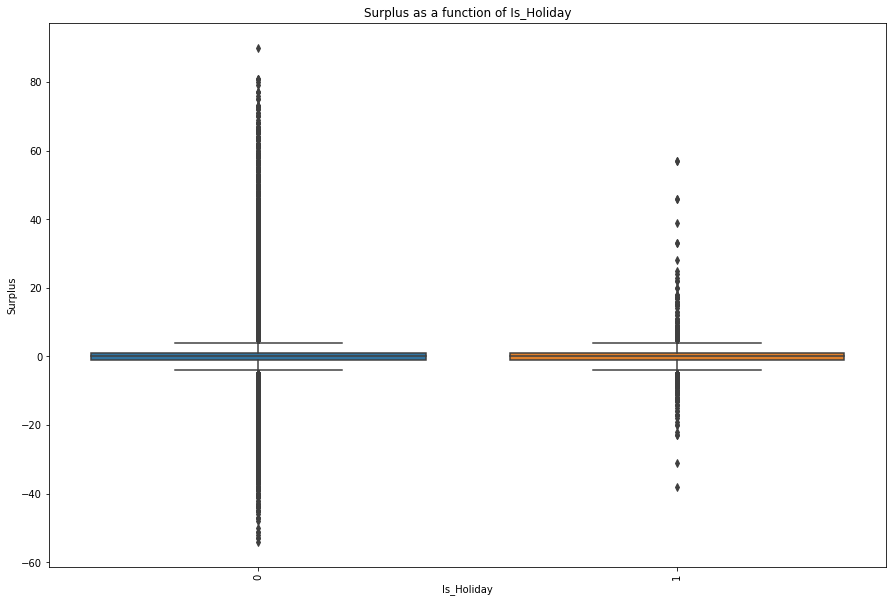

In [41]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Is_Holiday'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Is_Holiday')
plt.show()


# Predictions

In [42]:
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Weekdday,Weekday,Is_Holiday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,4,4,1
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,4,4,1
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,4,4,1
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,4,4,1
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,4,4,1


In [43]:
weather = pd.read_csv('data/weather/Weather.csv')
weather.head()

,Hour,Temperature,Apparent Temperature,Wind,Relative Humidity,Date
0,00:51,6°C,4°C,Variable à 7 Km/h,49%,2016-01-01
1,01:51,5°C,4°C,Variable à 6 Km/h,53%,2016-01-01
2,02:51,5°C,3°C,280°7 Km/h,57%,2016-01-01
3,03:51,5°C,2°C,280°15 Km/h,57%,2016-01-01
4,04:51,4°C,0°C,270°17 Km/h,61%,2016-01-01


In [44]:
import os
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        return self
    
    def transform(self,X_df):
        
        weather = pd.read_csv('data/weather/Weather.csv')

         
        def process_date(X):
            ts = pd.to_datetime(X[['Year','Month','Day']])
            X['weekday']= ts.dt.weekday
            cal=calendar()
            holidays = cal.holidays(start=ts.min(), end=ts.max()) 
            X['IsHoliday'] = ts.apply(lambda x: int(x in holidays))
            return np.c_[X['Year'], X['Month'], X['Day'],X['Hour'],X['weekday'],X['IsHoliday']]
        date_transformer = FunctionTransformer(process_date, validate=False)
        
        def process_station(X):
            return np.c_[X['Station ID'], X['Longitude'], X['Latitude']]
        station_transformer = FunctionTransformer(process_station, validate=False)

        def process_weather(X):

            date = pd.to_datetime(weather['Date'],format='%Y-%m-%d')
            weather['Year'] = date.dt.year
            weather['Month'] = date.dt.month
            weather['Day'] = date.dt.day
            weather['Hour'] = pd.to_datetime(weather['Hour'], format='%H:%M').dt.hour
            weather.drop_duplicates(subset =['Hour','Day','Month','Year'],keep = 'first',inplace=True) 
            def process_wind(x):
                if 'Rafales de Vent' in x:
                    return 2 # high value
                elif 'Calme' in x:
                    return 0 # low value
                else:
                    return 1 # medium value
            weather['Wind'] = weather['Wind'].apply(process_wind)
            weather['Apparent Temperature'] = (weather['Apparent Temperature'].str[:-2]).astype(float)
            weather['Temperature'] = (weather['Temperature'].str[:-2]).astype(float)
            weather['Relative Humidity'] = (weather['Relative Humidity'].str[:-1]).astype(float)
            df = pd.merge(X, weather, on=['Year', 'Month', 'Day', 'Hour'], how='left', left_index=True)
            return df[['Temperature', 'Apparent Temperature', 'Wind', 'Relative Humidity']] 

        
        weather_transformer = FunctionTransformer(process_weather, validate=False)


        date_cols = ['Year', 'Month', 'Day','Hour']
        station_cols = ['Station ID', 'Longitude', 'Latitude']
        merge_col = ['Year', 'Month', 'Day', 'Hour']
        drop_cols = ['Station Name']

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('weather', make_pipeline(weather_transformer, SimpleImputer(strategy='median')), merge_col),
                ('station', make_pipeline(station_transformer, SimpleImputer(strategy='median')), station_cols),
                ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
                ('drop cols', 'drop', drop_cols)
            ])

        
        X_array = self.preprocessor.fit_transform(X_df)
        return X_array

In [45]:
X_initial = FeatureExtractor()
X_transformed = X_initial.transform(X_df)
X_transformed


array([[ 6.,  4.,  1., ...,  0.,  4.,  1.],
       [ 6.,  4.,  1., ...,  0.,  4.,  1.],
       [ 6.,  4.,  1., ...,  0.,  4.,  1.],
       ...,
       [ 8.,  8.,  0., ..., 23.,  0.,  0.],
       [ 8.,  8.,  0., ..., 23.,  0.,  0.],
       [ 8.,  8.,  0., ..., 23.,  0.,  0.]])

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit

preprocessor = FeatureExtractor()
regressor = Regressor()

reg = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', regressor)])

cv = GroupShuffleSplit(n_splits=5, test_size=0.25)

scores_merge = -cross_val_score(reg, X_df, y_array, cv=cv, scoring=pinball_loss, groups=X_df['Station ID'],
                               n_jobs=2)

print("cross val scores ")
print(scores_merge)

cross val scores 
[1.37050108 1.66347158 1.22346185 1.29618961 1.19508363]


In [50]:
## use dummy regressor as a baseline to compare 

from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="median")
cv = GroupShuffleSplit(n_splits=5, test_size=0.25)

scores_merge_dummy = -cross_val_score(dummy_regr, X_df, y_array, cv=cv, scoring=pinball_loss, groups=X_df['Station ID'],
                               n_jobs=2)

print("cross val dummy scores")
print(scores_merge_dummy)

cross val dummy scores
[0.76832021 0.78268101 1.03591295 0.77116978 1.10223905]


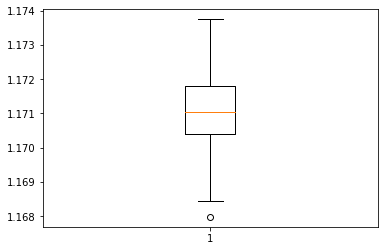

In [51]:
random_losses = []#uniform - add distribution from actual training data
for k in range(1000):
    random_losses.append(loss(y_array, np.random.randint(-3, 3, len(y_array))))
plt.boxplot(random_losses);


## Writing files and testing

In [52]:
%%file submissions/starting_kit/feature_extractor.py
import os
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        return self
    
    def transform(self,X_df):  
        
        weather = pd.read_csv('data/weather/Weather.csv')
        
        def process_date(X):
            ts = pd.to_datetime(X[['Year','Month','Day']])
            X['weekday']= ts.dt.weekday
            cal=calendar()
            holidays = cal.holidays(start=ts.min(), end=ts.max()) 
            X['IsHoliday'] = ts.apply(lambda x: int(x in holidays))
            return np.c_[X['Year'], X['Month'], X['Day'],X['Hour'],X['weekday'],X['IsHoliday']]
        date_transformer = FunctionTransformer(process_date, validate=False)
        
        def process_station(X):
            return np.c_[X['Station ID'], X['Longitude'], X['Latitude']]
        station_transformer = FunctionTransformer(process_station, validate=False)

        def process_weather(X):
            date = pd.to_datetime(weather['Date'],format='%Y-%m-%d')
            weather['Year'] = date.dt.year
            weather['Month'] = date.dt.month
            weather['Day'] = date.dt.day
            weather['Hour'] = pd.to_datetime(weather['Hour'], format='%H:%M').dt.hour
            weather.drop_duplicates(subset =['Hour','Day','Month','Year'],keep = 'first',inplace=True) 
            def process_wind(x):
                if 'Rafales de Vent' in x:
                    return 2 # high value
                elif 'Calme' in x:
                    return 0 # low value
                else:
                    return 1 # medium value
            weather['Wind'] = weather['Wind'].apply(process_wind)
            weather['Apparent Temperature'] = (weather['Apparent Temperature'].str[:-2]).astype(float)
            weather['Temperature'] = (weather['Temperature'].str[:-2]).astype(float)
            weather['Relative Humidity'] = (weather['Relative Humidity'].str[:-1]).astype(float)
            df = pd.merge(X, weather, on=['Year', 'Month', 'Day', 'Hour'], how='left', left_index=True)
            return df[['Temperature', 'Apparent Temperature', 'Wind', 'Relative Humidity']]   
        weather_transformer = FunctionTransformer(process_weather, validate=False)


        date_cols = ['Year', 'Month', 'Day','Hour']
        station_cols = ['Station ID', 'Longitude', 'Latitude']
        merge_col = ['Year', 'Month', 'Day', 'Hour']
        drop_cols = ['Station Name']

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('weather', make_pipeline(weather_transformer, SimpleImputer(strategy='median')), merge_col),
                ('station', make_pipeline(station_transformer, SimpleImputer(strategy='median')), station_cols),
                ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
                ('drop cols', 'drop', drop_cols)
            ])

        
        X_array = self.preprocessor.fit_transform(X_df)
        return X_array

Overwriting submissions/starting_kit/feature_extractor.py


In [53]:
%%file submissions/starting_kit/regressor.py
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

Overwriting submissions/starting_kit/regressor.py


In [54]:
!ramp_test_submission

Testing Prediction of NYC bike sharing service usage per station
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  pinball loss       time
	train          0.30  12.894550
	valid          1.31   5.451641
	test           0.93   2.233456
CV fold 1
	score  pinball loss       time
	train          0.31  14.844353
	valid          0.84   5.719187
	test           0.86   2.316118
CV fold 2
	score  pinball loss       time
	train          0.30  13.904073
	valid          1.34   5.491381
	test           0.89   2.257920
CV fold 3
	score  pinball loss       time
	train          0.30  11.048174
	valid          1.63   5.553806
	test           1.03   2.269392
CV fold 4
	score  pinball loss       time
	train          0.31  12.860767
	valid          0.95   5.584013
	test           0.88   2.207821
CV fold 5
	score  pinball loss       time
	train          0.28  12.091114
	valid          1.44   5.989978
	test           0.94   2.372398
CV fold 6